Important note to the reader willing to run the code below. After having installed ViZDoom github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md and cloned the following https://github.com/mwydmuch/ViZDoom, execute (for Linux):

> cd ../ViZDoom/examples

> jupyter notebook

then start this notebook...

In this capstone project we want to investigate various Q-Learning techniques to train an agent to play autonomously the game Doom in the ViZDoom environment

In this second notebook, we implement a basic DQN 

The following code has been adapted from github.com/mwydmuch/ViZDoom/tree/master/examples/python, specifically the file /ViZDoom/examples/python/basic.py, whose credit goes to the developers of the ViZDoom platform, an AI research platform for reinforcement learning from raw visual information: Michal Kempka, Grzegorz Runc, Jakub Toczek & Marek Wydmuch.

Main adaptations: 
- creation of global arrays to capture loss for each learning step and the loss mean for each epoch
- Epsilon decay function now of the form exp(-k*epoch) with k between 0,01 and 1
- matplolib to visualize training/testing scores and epoch-averaged loss


# 2. IMPLEMENTATION OF A BASIC DEEP Q-NETWORK

In [1]:
# setting up the notebook's environment

from __future__ import division
from __future__ import print_function
from vizdoom import *                       # this imports ViZDoom's Python API
import itertools as it
from random import sample, randint, random
from time import time, sleep
import numpy as np
import skimage.color, skimage.transform     # important to preprocess images received from the game
from random import choice                   # for random actions (exploration/exploitation)
import tensorflow as tf                     # the NN implementation will use TensorFlow
from tqdm import trange
import matplotlib.pyplot as plt             # for visualization
import math
import matplotlib.image as mpimg
%matplotlib inline

print("ok")


ok


In [2]:
# global parameters

learning_rate = 0.00025                  # this is the learning_rate for the tensor flow optimizer
discount_factor = 0.99 #0.99             # this is the gamma factor for the Bellman equation

epochs = 40
learning_steps_per_epoch = 2000 #number of learning steps per epoch / over which training will take place
replay_memory_size = 1000       # this is the size of the cyclic object storing the transitions

batch_size = 64     # is the size of the batch of transitions the function learn_from_memory() 
                    # collects and feeds into the neural network for learning purposes

test_episodes_per_epoch = 100   # Number of episodes we run during one training epoch

resolution = (30, 45)    # Resolution of the images (=the state s(t)) the agent gets from the env
episodes_to_watch = 10   # visual testing/watching at the end of training/testing

frame_repeat = 12                        # used to smooth watching, game.advance_action() routine

model_savefile = "/tmp/model.ckpt"       # where the weights/biases of the best model will be stored
save_model = True                        # flag: enabled to keep the best model
load_model = False                       # flag: disabled because we don't load a model
skip_learning = False                    # flag: enabled because we want the model to learn

# Configuration file path

# config_file_path = "../../scenarios/basic.cfg"             # Scenario "Basic"
config_file_path = "../../scenarios/health_gathering.cfg"    # Scenario "Health gathering supreme"
# config_file_path = "../../scenarios/deadly_corridor.cfg"   # Scenario "Deadly corridor"

print("done")

done


In [10]:
# global array that will collect the training & testing results
scoring_array = np.zeros((epochs,3), dtype = float)  # structure = [epoch, training_mean, testing_mean]

# we create global arrays to capture the loss values of each learning steps or each epoch
for i in range(epochs):
    i += 1
    globals()['loss_epoch_'+str(i)] = np.zeros((learning_steps_per_epoch,2), dtype = float)

print("done")

done


In [4]:
###########################################################################################
# preprocess (convenience) function                                                       #
###########################################################################################
# Converts and down-samples the input image according to the resolution                   #
#                                                                                         #
#  in                                                                                     #
#     img: the frames of the game, "game.get_state().screen_buffer"                       #
#     resolution: this is the global variable "resolution"                                #
#  out                                                                                    #
#     img: the converted and down-sampled image                                           #
#                                                                                         #
###########################################################################################
def preprocess(img):
    img = skimage.transform.resize(img, resolution)
    img = img.astype(np.float32)
    return img


###########################################################################################
# ReplayMemory Class                                                                      #
###########################################################################################
# Definition of the ReplayMemory Class and the corresponding child functions              #
# the object memory is created later, a cyclic memory storing transitions                 #
#                                                                                         #
#  in                                                                                     #
#     capacity: the size of this memory, global variable replay_memory_size               #
#     resolution: global variable resolution                                              #
#                                                                                         #
#  important note: transitions are structured around {s1, s2, a, isterminal, r}           #
#     - s1 is the state at time "t"                                                       #
#     - s2 is the state at time "t+1"                                                     #
#     - a is the action that has led from s1 to s2                                        #
#     - isterminal is boolean to check whether we have reached the max replay_memory_size #
#     - r is the reward associated to the s1->s2 transition                               # 
#                                                                                         #
#  out (functions provided to the object)                                                 #
#     "add_transition" = routine to increase the memory by one transition                 #
#          uses "self.pos" and "self.size" as pointers in the memory                      #
#     "get_sample" = routine to sample a number of transitions from the table             #
#                                                                                         #
#  2nd important note: Memory replay stores ALL transitions {s1, a ,s2 ,isterminal , r}   #
#                   for all “learning_steps_per_epoch” and for all “epochs” via the       #
#                   routine memory.add_transition() called by perform_learning_step().    # 
#                   The memory is cyclic and old transitions get overwritten              #
#                   as soon as the maximum memory size is reached                         # 
#                                                                                         #
###########################################################################################
class ReplayMemory:
    def __init__(self, capacity):
        channels = 1
        state_shape = (capacity, resolution[0], resolution[1], channels) # state = image
        self.s1 = np.zeros(state_shape, dtype=np.float32)      
        self.s2 = np.zeros(state_shape, dtype=np.float32)
        self.a = np.zeros(capacity, dtype=np.int32)
        self.r = np.zeros(capacity, dtype=np.float32)
        self.isterminal = np.zeros(capacity, dtype=np.float32) # isterminal flag

        self.capacity = capacity             # = global variable replay_memory_size
        self.size = 0
        self.pos = 0

    def add_transition(self, s1, action, s2, isterminal, reward): # called to store a new transition
        self.s1[self.pos, :, :, 0] = s1                           # s1 gets stored at position self.pos
        self.a[self.pos] = action                                 # a gest stored at position self.pos
        if not isterminal:
            self.s2[self.pos, :, :, 0] = s2                     # s2 gest stored at position self.pos
        self.isterminal[self.pos] = isterminal                  # isterminal stored at position self.pos
        self.r[self.pos] = reward                               # reward is stored at position self.pos

        self.pos = (self.pos + 1) % self.capacity               # self.pos incremented by one, = pointer
        self.size = min(self.size + 1, self.capacity)           # checks max size

    def get_sample(self, sample_size):               # sample_size = global var "batch_size"
        i = sample(range(0, self.size), sample_size) # select randomly a sample of size "sample_size"
                                                     # from the list
        return self.s1[i], self.a[i], self.s2[i], self.isterminal[i], self.r[i] 
                              #returns the selected list of transitions = the transition sample
        
    def get_current_size(self): # to perform checks on memory evolution
        return self.pos
    
print ("ok")

ok


In [11]:
###########################################################################################
# create_network function                                                                 #
###########################################################################################
# Definition of convolutional network implementing & callable functions                   #
#                                                                                         #
#  in                                                                                     #
#     session: this is the model (graph) instantiated as tf.Session()                     #
#     available_actions_count: len(actions) where actions is the list of action from      #
#                              game.get_available_buttons_size()                          #
#                                                                                         #
#  important note:                                                                        #
#     we don't use pooling layers because we want to keep the location of the object      #
#                                                                                         #
#  out                                                                                    #
#     function_learn()                                                                    #
#     function_get_q_values()                                                             #
#     function_simple_get_best_action()                                                   #
#                                                                                         #
###########################################################################################
def create_network(session, available_actions_count):
    
    # Create the input variables / placeholders
    s1_ = tf.placeholder(tf.float32, [None] + list(resolution) + [1], name="State")
    a_ = tf.placeholder(tf.int32, [None], name="Action")
    target_q_ = tf.placeholder(tf.float32, [None, available_actions_count], name="TargetQ")

    # 1st convolutional layer
    conv1 = tf.contrib.layers.convolution2d(s1_, num_outputs=32, kernel_size=8, stride=4,
                                            activation_fn=tf.nn.relu,
                                            weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True),
                                            biases_initializer=tf.constant_initializer(0.1))
    
    # 2nd convolutional layer 
    conv2 = tf.contrib.layers.convolution2d(conv1, num_outputs=64, kernel_size=4, stride=2,
                                            activation_fn=tf.nn.relu,
                                            weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True),
                                            biases_initializer=tf.constant_initializer(0.1))
    
    # 3rd convolutional layer 
    conv3 = tf.contrib.layers.convolution2d(conv2, num_outputs=64, kernel_size=3, stride=1,
                                            activation_fn=tf.nn.relu,
                                            weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True),
                                            biases_initializer=tf.constant_initializer(0.1))    
    
    # flattening layer
    conv3_flat = tf.contrib.layers.flatten(conv3)
    
    # 1st fully connected layer
    fc1 = tf.contrib.layers.fully_connected(conv3_flat, num_outputs=256, activation_fn=tf.nn.relu,
                                            weights_initializer=tf.contrib.layers.xavier_initializer(),
                                            biases_initializer=tf.constant_initializer(0.1))
    
    # 2nd fully connected layer, NO activation function: best action calculated with argmax()
    # the number of ouptuts is "available_actions_count", where a q value if computer for each action 
    q = tf.contrib.layers.fully_connected(fc1, num_outputs=available_actions_count, activation_fn=None,
                                          weights_initializer=tf.contrib.layers.xavier_initializer(),
                                          biases_initializer=tf.constant_initializer(0.1))
    
    best_a = tf.argmax(q, 1) # best action is the highest q-value among the q vector of 
                             # size "available_actions_count"
    
    loss = tf.losses.mean_squared_error(q, target_q_)   # the loss function
        
    optimizer = tf.train.RMSPropOptimizer(learning_rate) # RMS-backpropagation with gradient descent 
    train_step = optimizer.minimize(loss)                # on loss
        
        
    ###########################################################################################
    # function_learn() function                                                               #
    ###########################################################################################
    #  in                                                                                     #
    #     s1: a list of "batch_size" states                                                   #
    #     target_q: a list of "batch_size" target_q                                           #
    #     epoch: is passed here to be stored with the loss values in the array for this epoch #
    #     learning_step: is passed here to be stored with the loss value of this learning step#
    #                                                                                         #
    #  out                                                                                    #   
    #     l:     the MSE score which is stored in the epoch-corresponding array               #
    #                                                                                         #
    ###########################################################################################
    def function_learn(s1, target_q, epoch, learning_step):
        feed_dict = {s1_: s1, target_q_: target_q}
        l, _ = session.run([loss, train_step], feed_dict=feed_dict)
   
        k = epoch + 1
        # (globals()['loss_epoch_'+str(k)])[learning_step,0] = learning_step
        (globals()['loss_epoch_'+str(k)])[learning_step,1] = l # we capture l
        return l

    
    ###########################################################################################
    # function_get_q_values() function                                                        #
    ###########################################################################################
    #  in                                                                                     #
    #     state: a vector of "batch_size" states                                              #
    #                                                                                         #
    #  out                                                                                    #   
    #     a matrix with all "available_actions_count" q values                                #
    #     for all these states in the batch                                                   #
    #                                                                                         #
    ###########################################################################################
    def function_get_q_values(state):
        return session.run(q, feed_dict={s1_: state})

    
    ###########################################################################################
    # function_simple_get_best_action() function                                              #
    ###########################################################################################
    #  in                                                                                     #
    #     state: a vector of "batch_size" states                                              #
    #                                                                                         #
    #  out                                                                                    #   
    #     the vector of the best action for each of the states                                #
    #                                                                                         #
    ###########################################################################################
    def function_get_best_action(state):
        return session.run(best_a, feed_dict={s1_: state})

    def function_simple_get_best_action(state):
        return function_get_best_action(state.reshape([1, resolution[0], resolution[1], 1]))[0]

    return function_learn, function_get_q_values, function_simple_get_best_action   
                            # the 3 functions made available for the object network

print("done")

done


In [6]:
# Learning functions

###########################################################################################
# learn_from_memory() function                                                            #
###########################################################################################
# This is the function which is called after each learning step to train the network,     #
# through perform_learning_step():                                                        #
#                                                                                         #
# - it calls memory.get_sample() to get the batch of transitions (of size batch_size)     #
#                                                                                         #
# - it computes the max q_values for all the states s2 (in the batch) with get_q_values(),#
# q_values are estimated by the network                                                   #
#                                                                                         #
# - it calls get_q_values() to get the target_q values of all states s1 from the batch,   #
# target_q values estimated by the network                                                #
#                                                                                         #
# - it computes the Bellman equation for all target_qs (for the action of this transition)#
#                                                                                         #
# - then triggers learn() for this batch of transitions with their "new" target_q values  #
#                                                                                         #
#  in                                                                                     #
#     epoch: passed on here because needed in learn(), to store loss values               #
#     learning_step: passed on here because needed in learn(), to store loss values       #
#                                                                                         #
###########################################################################################
def learn_from_memory(epoch, learning_step):

    # Get a random minibatch from the replay memory and learns from it.
    if memory.size > batch_size: # means there is enough memory to extract a batch of this size
        s1, a, s2, isterminal, r = memory.get_sample(batch_size)

        q2 = np.max(get_q_values(s2), axis=1)
        target_q = get_q_values(s1)
        # target_Q(s,a) = r + gamma * max Q(s2,_) if isterminal, else r, the Bellman equation
        target_q[np.arange(target_q.shape[0]), a] = r + discount_factor * (1 - isterminal) * q2
        learn(s1, target_q, epoch, learning_step)   # new round of learning for the network
        
        
###########################################################################################
# perform_learning_step() function                                                        #
###########################################################################################
# This dunction let the agent make an action according to the epsilon-greedy policy,      #
# and observe the result (next state, reward) and learns from the transition              #
#                                                                                         #
#  in                                                                                     #
#     epoch: required to compute epsilon in current epoch (it decays over the epochs)     #
#     learning_step: passed here because required in learn_from_memory(), to store loss   #
#                                                                                         #
###########################################################################################        
def perform_learning_step(epoch, learning_step):

    def exploration_rate(epoch):
        # exploration rate decaying over epochs / optimize exploration 
        # eps = math.exp(-0.01*epoch)   # more exploration
        eps = math.exp(-0.1*epoch)      # starting point (coming from smart cab miniproject)
        # eps = math.exp(-epoch)        # more exploitation
        return eps
            
    s1 = preprocess(game.get_state().screen_buffer)

    # With probability eps, makes a random action
    eps = exploration_rate(epoch)
    if random() <= eps:
        a = randint(0, len(actions) - 1)    # random action
    else:
        a = get_best_action(s1)             # the best action according to the network
    
    reward = game.make_action(actions[a], frame_repeat)    # collects reward from game

    isterminal = game.is_episode_finished()
    
    s2 = preprocess(game.get_state().screen_buffer) if not isterminal else None

    # store the transition that was just experienced
    memory.add_transition(s1, a, s2, isterminal, reward)

    learn_from_memory(epoch, learning_step)     # starts learning for the network
    
print("done")

done


In [7]:
# Creates and initializes ViZDoom environment.
# game is the object that will own the ViZDoom's Python API routines

def initialize_vizdoom(config_file_path):
    print("Initializing doom...")
    game = DoomGame()
    game.load_config(config_file_path)
    game.set_window_visible(False)
    game.set_mode(Mode.PLAYER)
    game.set_screen_format(ScreenFormat.GRAY8)               # the provided images are grey-scaled
    game.set_screen_resolution(ScreenResolution.RES_640X480)
    game.init()
    print("Doom initialized.")
    return game

print("done")

done


Initializing doom...
Doom initialized.
Starting with training!

Epoch 1
-------
Training...


  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  0%|          | 0/100 [00:00<?, ?it/s]            

51 training episodes played.
Results: mean: 359.9±125.7, min: 156.0, max: 764.0, RM size: 2000.0, loss: 250032933.8,

Testing...


Results: mean: 302.6±30.1, min: 284.0 max: 444.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 7.98 minutes

Epoch 2
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

54 training episodes played.
Results: mean: 332.9±86.1, min: 156.0, max: 668.0, RM size: 4000.0, loss: 641337.7,

Testing...


Results: mean: 284.0±0.0, min: 284.0 max: 284.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 15.29 minutes

Epoch 3
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

53 training episodes played.
Results: mean: 341.7±86.3, min: 40.0, max: 572.0, RM size: 6000.0, loss: 6101.9,

Testing...


Results: mean: 300.0±58.7, min: 156.0 max: 732.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 22.42 minutes

Epoch 4
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

53 training episodes played.
Results: mean: 348.6±83.4, min: 220.0, max: 572.0, RM size: 8000.0, loss: 2046.0,

Testing...


Results: mean: 334.5±94.2, min: 156.0 max: 604.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 29.99 minutes

Epoch 5
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

54 training episodes played.
Results: mean: 337.8±100.3, min: 156.0, max: 732.0, RM size: 0.0, loss: 1575.0,

Testing...


Results: mean: 354.4±120.4, min: 156.0 max: 988.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 37.74 minutes

Epoch 6
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

56 training episodes played.
Results: mean: 319.6±95.5, min: 124.0, max: 636.0, RM size: 2000.0, loss: 1442.3,

Testing...


Results: mean: 284.0±0.0, min: 284.0 max: 284.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 45.17 minutes

Epoch 7
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

56 training episodes played.
Results: mean: 319.5±87.5, min: 156.0, max: 636.0, RM size: 4000.0, loss: 1148.5,

Testing...


Results: mean: 348.6±120.9, min: 116.0 max: 701.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 52.41 minutes

Epoch 8
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

55 training episodes played.
Results: mean: 328.6±88.2, min: 124.0, max: 636.0, RM size: 6000.0, loss: 875.6,

Testing...


Results: mean: 285.9±12.7, min: 252.0 max: 380.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 59.58 minutes

Epoch 9
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

53 training episodes played.
Results: mean: 344.4±83.1, min: 156.0, max: 604.0, RM size: 8000.0, loss: 804.6,

Testing...


Results: mean: 288.2±27.4, min: 156.0 max: 348.0
Saving the network weigths to: /tmp/model.ckpt
Total elapsed time: 66.93 minutes

Epoch 10
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

49 training episodes played.
Results: mean: 378.8±131.5, min: 28.0, max: 892.0, RM size: 0.0, loss: 872.8,

Testing...


Results: mean: 331.4±99.9, min: 156.0 max: 828.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 74.43 minutes

Epoch 11
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

56 training episodes played.
Results: mean: 320.5±90.7, min: 156.0, max: 796.0, RM size: 2000.0, loss: 744.6,

Testing...


Results: mean: 311.2±45.6, min: 156.0 max: 476.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 81.75 minutes

Epoch 12
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

55 training episodes played.
Results: mean: 328.2±95.8, min: 156.0, max: 604.0, RM size: 4000.0, loss: 766.5,

Testing...


Results: mean: 392.4±161.4, min: 119.0 max: 1084.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 89.26 minutes

Epoch 13
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

55 training episodes played.
Results: mean: 326.7±109.2, min: 156.0, max: 668.0, RM size: 6000.0, loss: 708.2,

Testing...


Results: mean: 285.0±16.6, min: 156.0 max: 348.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 96.48 minutes

Epoch 14
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

54 training episodes played.
Results: mean: 339.1±84.8, min: 188.0, max: 668.0, RM size: 8000.0, loss: 705.8,

Testing...


Results: mean: 284.6±6.4, min: 284.0 max: 348.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 103.75 minutes

Epoch 15
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

58 training episodes played.
Results: mean: 310.4±68.6, min: 156.0, max: 604.0, RM size: 0.0, loss: 697.9,

Testing...


Results: mean: 284.0±15.7, min: 156.0 max: 348.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 110.98 minutes

Epoch 16
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

57 training episodes played.
Results: mean: 314.7±55.6, min: 149.0, max: 503.0, RM size: 2000.0, loss: 738.1,

Testing...


Results: mean: 284.6±6.4, min: 284.0 max: 348.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 118.27 minutes

Epoch 17
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

60 training episodes played.
Results: mean: 292.9±56.5, min: 156.0, max: 444.0, RM size: 4000.0, loss: 715.8,

Testing...


Results: mean: 292.5±20.1, min: 284.0 max: 348.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 125.78 minutes

Epoch 18
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

57 training episodes played.
Results: mean: 317.5±70.7, min: 156.0, max: 508.0, RM size: 6000.0, loss: 673.3,

Testing...


Results: mean: 287.8±24.5, min: 156.0 max: 444.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 133.11 minutes

Epoch 19
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

58 training episodes played.
Results: mean: 306.1±62.7, min: 156.0, max: 572.0, RM size: 8000.0, loss: 695.6,

Testing...


Results: mean: 284.0±0.0, min: 284.0 max: 284.0
Saving the network weigths to: /tmp/model.ckpt
Total elapsed time: 140.29 minutes

Epoch 20
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

60 training episodes played.
Results: mean: 295.8±39.9, min: 181.0, max: 444.0, RM size: 0.0, loss: 681.0,

Testing...


Results: mean: 291.4±23.9, min: 284.0 max: 444.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 1/2000 [00:00<06:15,  5.33it/s]

Total elapsed time: 147.57 minutes

Epoch 21
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

59 training episodes played.
Results: mean: 297.8±50.5, min: 156.0, max: 476.0, RM size: 2000.0, loss: 714.5,

Testing...


Results: mean: 282.7±12.7, min: 156.0 max: 284.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 154.89 minutes

Epoch 22
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

61 training episodes played.
Results: mean: 287.4±54.0, min: 118.0, max: 444.0, RM size: 4000.0, loss: 661.7,

Testing...


Results: mean: 285.0±7.1, min: 284.0 max: 348.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 162.09 minutes

Epoch 23
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

61 training episodes played.
Results: mean: 289.7±44.1, min: 156.0, max: 444.0, RM size: 6000.0, loss: 658.1,

Testing...


Results: mean: 284.0±0.0, min: 284.0 max: 284.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 169.68 minutes

Epoch 24
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

60 training episodes played.
Results: mean: 294.7±24.6, min: 252.0, max: 348.0, RM size: 8000.0, loss: 646.7,

Testing...


Results: mean: 284.0±0.0, min: 284.0 max: 284.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 176.79 minutes

Epoch 25
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

60 training episodes played.
Results: mean: 297.9±33.7, min: 252.0, max: 444.0, RM size: 0.0, loss: 631.9,

Testing...


Results: mean: 284.0±0.0, min: 284.0 max: 284.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 184.00 minutes

Epoch 26
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

61 training episodes played.
Results: mean: 291.7±36.3, min: 176.0, max: 444.0, RM size: 2000.0, loss: 620.3,

Testing...


  0%|          | 0/2000 [00:00<?, ?it/s]         

Results: mean: 284.0±0.0, min: 284.0 max: 284.0
Saving the network weigths to: /tmp/model.ckpt
Total elapsed time: 191.20 minutes

Epoch 27
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

60 training episodes played.
Results: mean: 293.7±29.9, min: 156.0, max: 348.0, RM size: 4000.0, loss: 570.3,

Testing...


Results: mean: 284.0±0.0, min: 284.0 max: 284.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 198.41 minutes

Epoch 28
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

59 training episodes played.
Results: mean: 303.0±46.1, min: 220.0, max: 508.0, RM size: 6000.0, loss: 567.7,

Testing...


Results: mean: 309.2±67.2, min: 156.0 max: 604.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 205.64 minutes

Epoch 29
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

52 training episodes played.
Results: mean: 347.7±122.8, min: 156.0, max: 828.0, RM size: 8000.0, loss: 624.9,

Testing...


Results: mean: 352.8±117.6, min: 156.0 max: 755.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 213.43 minutes

Epoch 30
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

53 training episodes played.
Results: mean: 341.9±98.2, min: 156.0, max: 668.0, RM size: 0.0, loss: 710.0,

Testing...


Results: mean: 319.5±85.1, min: 156.0 max: 636.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 221.08 minutes

Epoch 31
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

53 training episodes played.
Results: mean: 345.2±143.9, min: 156.0, max: 1148.0, RM size: 2000.0, loss: 793.4,

Testing...


Results: mean: 336.0±98.3, min: 156.0 max: 956.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 228.70 minutes

Epoch 32
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

56 training episodes played.
Results: mean: 323.3±84.1, min: 156.0, max: 604.0, RM size: 4000.0, loss: 661.0,

Testing...


Results: mean: 343.1±120.4, min: 156.0 max: 860.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 236.26 minutes

Epoch 33
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

47 training episodes played.
Results: mean: 400.0±155.1, min: 156.0, max: 924.0, RM size: 6000.0, loss: 572.9,

Testing...


Results: mean: 347.4±113.0, min: 156.0 max: 668.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 244.22 minutes

Epoch 34
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

46 training episodes played.
Results: mean: 410.9±212.6, min: 28.0, max: 1180.0, RM size: 8000.0, loss: 725.9,

Testing...


Results: mean: 396.2±175.6, min: 156.0 max: 1052.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 252.02 minutes

Epoch 35
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

47 training episodes played.
Results: mean: 396.8±152.6, min: 156.0, max: 924.0, RM size: 0.0, loss: 829.3,

Testing...


Results: mean: 334.2±78.9, min: 156.0 max: 572.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 1/2000 [00:00<06:29,  5.14it/s]

Total elapsed time: 259.58 minutes

Epoch 36
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

51 training episodes played.
Results: mean: 364.2±129.1, min: 156.0, max: 636.0, RM size: 2000.0, loss: 851.8,

Testing...


Results: mean: 380.0±148.5, min: 95.0 max: 892.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 267.59 minutes

Epoch 37
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

49 training episodes played.
Results: mean: 382.9±126.0, min: 156.0, max: 700.0, RM size: 4000.0, loss: 739.9,

Testing...


Results: mean: 332.4±97.7, min: 113.0 max: 668.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 275.26 minutes

Epoch 38
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

51 training episodes played.
Results: mean: 353.4±84.6, min: 156.0, max: 643.0, RM size: 6000.0, loss: 639.3,

Testing...


Results: mean: 378.9±164.3, min: 124.0 max: 1116.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 282.93 minutes

Epoch 39
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

49 training episodes played.
Results: mean: 376.4±136.0, min: 156.0, max: 732.0, RM size: 8000.0, loss: 630.3,

Testing...


Results: mean: 384.8±150.1, min: 156.0 max: 1084.0
Saving the network weigths to: /tmp/model.ckpt


  0%|          | 0/2000 [00:00<?, ?it/s]

Total elapsed time: 290.92 minutes

Epoch 40
-------
Training...


  0%|          | 0/100 [00:00<?, ?it/s]            

50 training episodes played.
Results: mean: 367.9±128.3, min: 156.0, max: 732.0, RM size: 0.0, loss: 834.8,

Testing...


Results: mean: 376.7±137.8, min: 60.0 max: 1020.0
Saving the network weigths to: /tmp/model.ckpt
Total elapsed time: 298.76 minutes
Training finished


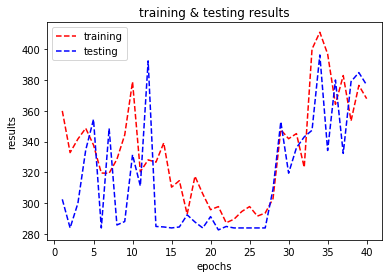

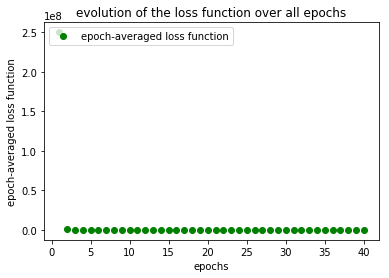

Total score:  397.0
Total score:  268.0
Total score:  429.0
Total score:  499.0
Total score:  277.0
Total score:  341.0
Total score:  341.0
Total score:  342.0
Total score:  401.0
Total score:  656.0


In [12]:
# MAIN PROGRAM - A HIGH LEVEL LOGICAL VIEW OF THIS PROGRAM IS AVAILABLE IN MY REPORT 

# Create Doom instance
game = initialize_vizdoom(config_file_path)

# Action = which buttons/actions can be selected by the agent
n = game.get_available_buttons_size()
actions = [list(a) for a in it.product([0, 1], repeat=n)]

# Create replay memory storing the transitions
memory = ReplayMemory(capacity=replay_memory_size)

# Create tf session
session = tf.Session()

# The three routines made available at network creation
learn, get_q_values, get_best_action = create_network(session, len(actions))
saver = tf.train.Saver()
if load_model:
    print("Loading model from: ", model_savefile)
    saver.restore(session, model_savefile)
else:
    init = tf.global_variables_initializer()
    session.run(init)

print("Starting with training!")

time_start = time()

if not skip_learning:
    for epoch in range(epochs):                               # the epoch loop
        print("\nEpoch %d\n-------" % (epoch + 1))
        train_episodes_finished = 0
        train_scores = []

        print("Training...")
        game.new_episode()
        for learning_step in trange(learning_steps_per_epoch, leave=False): # the learning_step loop
            perform_learning_step(epoch, learning_step)
            if game.is_episode_finished():
                score = game.get_total_reward()
                train_scores.append(score)
                game.new_episode()
                train_episodes_finished += 1

        print("%d training episodes played." % train_episodes_finished)
        train_scores = np.array(train_scores)
        
        k = 0
        k = epoch+1     # we store the mean (over one epoch) of the computed loss at each epoch
        globals()['l_'+str(k)] = np.mean(globals()['loss_epoch_'+str(k)], axis=0)[1]
        epoch_loss = globals()['l_'+str(k)]
        
        print("Results: mean: %.1f±%.1f," % (train_scores.mean(), train_scores.std()), \
                  "min: %.1f," % train_scores.min(), "max: %.1f," % train_scores.max(),  \
                  "RM size: %.1f," % memory.get_current_size(), "loss: %.1f," % epoch_loss)
                    
        scoring_array[epoch,0] = epoch+1
        scoring_array[epoch,1] = train_scores.mean()

                   
        print("\nTesting...")
        test_episode = []
        test_scores = []
        for test_episode in trange(test_episodes_per_epoch, leave=False):
            game.new_episode()
            while not game.is_episode_finished():
                bidule = game.get_state().screen_buffer  # to display a given state, otherwise not used
                state = preprocess(bidule)
                
                # to display a given state
                '''if ((epoch == 0) & (test_episode == 1)):
                    plt.plot(bidule) 
                    plt.title('this is what a frame looks like')
                    plt.imshow(bidule)
                    plt.savefig('../../pictures/frame_HG_1.png', dpi = 300)
                    plt.gcf().clear()
                    plt.plot(state) 
                    plt.title('this is what a state looks like')
                    plt.imshow(state)
                    plt.savefig('../../pictures/state_HG_1.png', dpi = 300)
                    plt.gcf().clear()'''
                               
                best_action_index = get_best_action(state)
                game.make_action(actions[best_action_index], frame_repeat)
            r = game.get_total_reward()
            test_scores.append(r)

        test_scores = np.array(test_scores)
        print("Results: mean: %.1f±%.1f," % (test_scores.mean(), test_scores.std()), "min: %.1f" % test_scores.min(),
                  "max: %.1f" % test_scores.max())
        
        scoring_array[epoch,2] = test_scores.mean()
              
        print("Saving the network weigths to:", model_savefile)
        saver.save(session, model_savefile)
        
        print("Total elapsed time: %.2f minutes" % ((time() - time_start) / 60.0))
               
game.close()

print("======================================")
print("Training finished")

# we display the results with matplotlib - training then testing
plt.plot(scoring_array[:,0], scoring_array[:,1], 'r--',scoring_array[:,0], scoring_array[:,2], 'b--') 
plt.title('training & testing results')
plt.ylabel('results')
plt.xlabel('epochs')
plt.legend(['training', 'testing'], loc='upper left')
plt.show()
plt.savefig('../../pictures/training_testing.png', dpi = 300)
plt.gcf().clear()

# we visualize the averaged loss for all epochs
for i in range(epochs):
    i += 1
    # globals()['l_'+str(i)] = np.mean(globals()['loss_epoch_'+str(i)], axis=0)[1]
    plt.plot(i,globals()['l_'+str(i)],'go')
plt.title('evolution of the loss function over all epochs')
plt.ylabel('epoch-averaged loss function')
plt.xlabel('epochs')
plt.legend(['epoch-averaged loss function'], loc='upper left')
plt.show()
plt.savefig('../../pictures/loss_all_epochs.png', dpi = 300)
plt.gcf().clear()

# Reinitialize the game with window visible
game.set_window_visible(True)
game.set_mode(Mode.ASYNC_PLAYER)
game.init()

for _ in range(episodes_to_watch):
    game.new_episode()
    while not game.is_episode_finished():
        state = preprocess(game.get_state().screen_buffer)
        best_action_index = get_best_action(state)

        # Instead of make_action(a, frame_repeat) in order to make the animation smooth
        game.set_action(actions[best_action_index])
        for _ in range(frame_repeat):
            game.advance_action()

    # Sleep between episodes
    sleep(1.0)
    score = game.get_total_reward()
    print("Total score: ", score)    

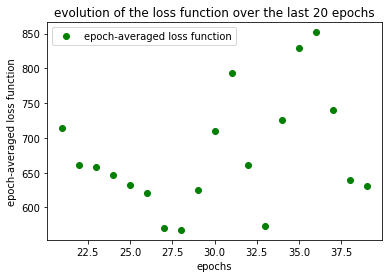

In [13]:
# scale change for function loss
# we display the last 20 epochs

for k in range(21, epochs):
    plt.plot(k,globals()['l_'+str(k)],'go')
plt.title('evolution of the loss function over the last 20 epochs')
plt.ylabel('epoch-averaged loss function')
plt.xlabel('epochs')
plt.legend(['epoch-averaged loss function'], loc='upper left')
plt.show()
# plt.savefig('../../pictures/loss_all_epochs.png', dpi = 300)
plt.gcf().clear()
